Physical GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Copied dataset to local: /content/dataset_local/final
Classes: ['jackfruit', 'mango']
Samples → train=943, val=228, test=177
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

[VGG16 Transfer | fraction=1.00]  train_samples=943  params=14,846,530  train_time=88.3s  test_time=12.3s  test_acc=0.989


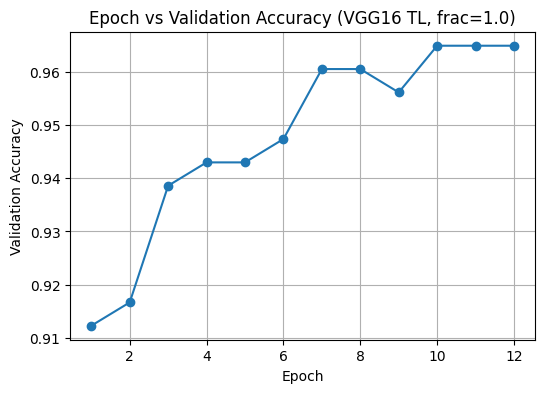

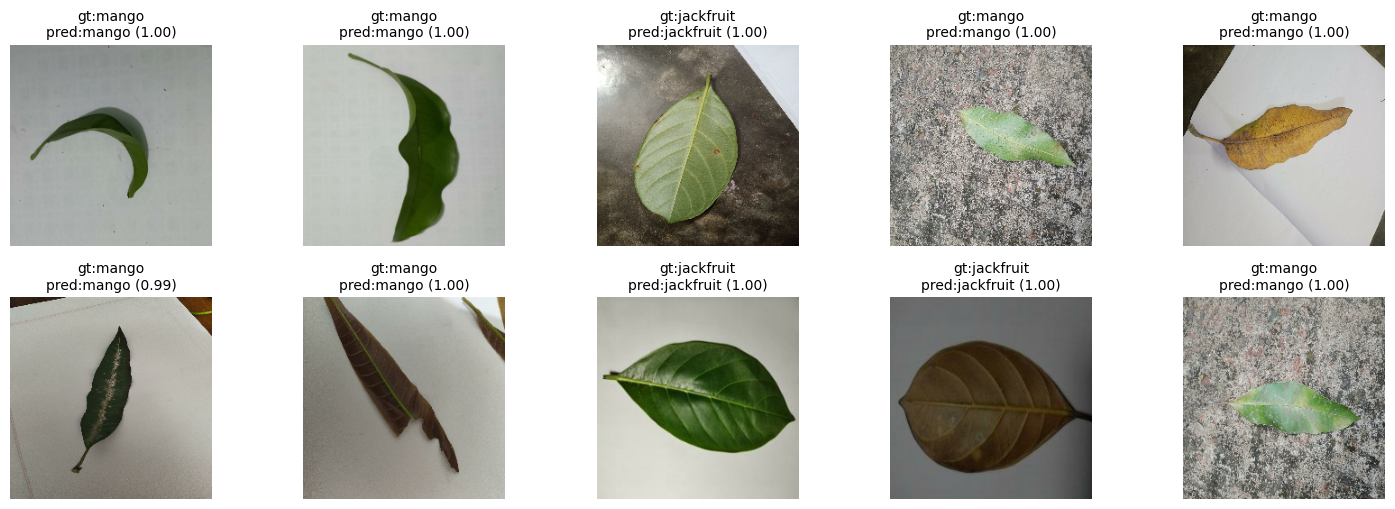

                              file        gt      pred     prob
  photo_32_2025-10-07_20-39-42.jpg     mango     mango 0.999713
  photo_83_2025-10-07_20-39-03.jpg     mango     mango 0.999853
             IMG20250927120444.jpg jackfruit jackfruit 0.999927
         IMG20251010164342 (1).jpg     mango     mango 0.999997
             IMG20250927120932.jpg     mango     mango 0.999849
 IMG_20251011_172438872(1) (1).jpg     mango     mango 0.994892
        IMG_20251011_173942240.jpg     mango     mango 0.999852
           IMG_20230308_133352.jpg jackfruit jackfruit 0.999844
brightened_IMG_20230308_110631.jpg jackfruit jackfruit 0.999999
             IMG20251010164339.jpg     mango     mango 0.997639

[VGG16 Transfer | fraction=1.00]  train_samples=943  params=14,846,530  train_time=64.6s  test_time=1.0s  test_acc=0.994

[VGG16 Transfer | fraction=0.50]  train_samples=471  params=14,846,530  train_time=43.5s  test_time=1.0s  test_acc=0.955

[VGG16 Transfer | fraction=0.25]  train_samples=235

In [1]:
# === TF/Keras: VGG16 Transfer Learning + Report + 10 Sample Predictions (PRINT ONLY; 2 FIGURES) ===
# - Copies dataset once from Drive -> local for faster I/O
# - VGG16 (ImageNet) backbone + small custom head
# - Prints training/testing time
# - Figure 1: Epoch vs Validation Accuracy (baseline run)
# - Figure 2: Grid of 10 test images with GT + predicted labels (+ table)
# - Amount-of-data vs performance table
# - No files are saved

import os, time, random, shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
# ⚠️ আপনার Drive পাথ ঠিক করুন (অতিরিক্ত স্পেস যেন না থাকে):
DRIVE_ROOT = "/content/drive/MyDrive/AI assignment /final"   # must contain train/val/test
LOCAL_ROOT = "/content/dataset_local/final"

IMG_SIZE  = (224, 224)   # VGG16-এর ডিফল্ট সাইজ
BATCH     = 32
EPOCHS    = 12
SEED      = 42
AUTOTUNE  = tf.data.AUTOTUNE

# Amount-of-data sweep
FRACTIONS = [1.00, 0.50, 0.25]
# ---------------------------------------

# GPU + (optional) mixed precision; শেষ Dense-এ float32 রাখা হবে
print("Physical GPUs:", tf.config.list_physical_devices('GPU'))
try:
    tf.keras.mixed_precision.set_global_policy("mixed_float16")
except Exception as e:
    print("Mixed precision not set:", e)

# Reproducibility
tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED); random.seed(SEED)

# ---------------- Dataset staging (Drive -> local) ----------------
def stage_dataset(drive_root, local_root):
    must = ["train","val","test"]
    for m in must:
        if not os.path.exists(os.path.join(drive_root, m)):
            raise FileNotFoundError(f"Missing folder: {m} under {drive_root}")
    if not (os.path.exists(local_root) and all(os.path.exists(os.path.join(local_root,m)) for m in must)):
        if os.path.exists(local_root):
            shutil.rmtree(local_root)
        os.makedirs(os.path.dirname(local_root), exist_ok=True)
        shutil.copytree(drive_root, local_root)
        print("Copied dataset to local:", local_root)
    else:
        print("Using existing local copy:", local_root)
    return local_root

DATA_ROOT = stage_dataset(DRIVE_ROOT, LOCAL_ROOT)  # use local for speed

# ---------------- Dataset helpers ----------------
def list_class_files(dir_path: str):
    classes = sorted([d for d in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path,d))])
    files, labels = [], []
    for idx, cname in enumerate(classes):
        cdir = os.path.join(dir_path, cname)
        for root, _, fnames in os.walk(cdir):
            for fn in fnames:
                if fn.lower().endswith((".jpg",".jpeg",".png",".bmp",".webp",".tif",".tiff")):
                    files.append(os.path.join(root, fn)); labels.append(idx)
    return files, labels, classes

def make_ds_from_files(files, labels, batch=BATCH, shuffle=False):
    files  = tf.convert_to_tensor(files, dtype=tf.string)
    labels = tf.convert_to_tensor(labels, dtype=tf.int32)
    ds = tf.data.Dataset.from_tensor_slices((files, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(files), seed=SEED, reshuffle_each_iteration=True)

    # VGG16 expects BGR-centered preprocessed float; preprocess_input handles it.
    def _load(path, y):
        img = tf.io.read_file(path)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize(img, IMG_SIZE, method=tf.image.ResizeMethod.BILINEAR)
        img.set_shape(IMG_SIZE + (3,))
        img = tf.cast(img, tf.float32)
        img = preprocess_input(img)  # <-- key change for VGG16
        return img, y

    ds = ds.map(_load, num_parallel_calls=AUTOTUNE)
    ds = ds.cache()                      # চাইলে ডিস্ক-ক্যাশে দিতে পারেন: .cache(os.path.join(LOCAL_ROOT, ".tf_cache"))
    ds = ds.batch(batch).prefetch(AUTOTUNE)
    return ds

def load_full_splits(root: str):
    tr_files, tr_labels, class_names = list_class_files(os.path.join(root, "train"))
    va_files, va_labels, _           = list_class_files(os.path.join(root, "val"))
    te_files, te_labels, _           = list_class_files(os.path.join(root, "test"))
    val_ds  = make_ds_from_files(va_files, va_labels, shuffle=False)
    test_ds = make_ds_from_files(te_files, te_labels, shuffle=False)
    meta = {"class_names": class_names,
            "train_files": tr_files, "train_labels": tr_labels,
            "val_files": va_files,   "val_labels": va_labels,
            "test_files": te_files,  "test_labels": te_labels}
    return meta, val_ds, test_ds

def make_train_subset(meta, fraction: float):
    tr_files, tr_labels = meta["train_files"], meta["train_labels"]
    n_total = len(tr_files); n_keep = max(1, int(n_total * fraction))
    idx = np.random.default_rng(SEED).permutation(n_total)[:n_keep]
    files_sub  = [tr_files[i]  for i in idx]
    labels_sub = [tr_labels[i] for i in idx]
    return make_ds_from_files(files_sub, labels_sub, shuffle=True), n_keep

# ---------------- VGG16 Transfer Learning Model ----------------
def build_vgg16_transfer(num_classes: int) -> tf.keras.Model:
    # VGG16 base (pretrained, no top)
    base = VGG16(include_top=False, weights="imagenet", input_shape=IMG_SIZE + (3,))
    base.trainable = False  # frozen backbone (simple transfer learning)

    inputs = layers.Input(shape=IMG_SIZE + (3,))
    x = inputs
    # (Augmentation চাইলে এখানে দিতে পারেন)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax", dtype="float32")(x)
    return models.Model(inputs, outputs, name="vgg16_transfer")

def compile_model(m):
    # AdamW ব্যবহার করতে চাইলে TF ভার্সন সাপোর্ট করতে হবে; সেফ-চয়েস Adam
    opt = tf.keras.optimizers.Adam(learning_rate=3e-4)
    m.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return m

# ---------------- Train/eval once ----------------
def train_once(fraction: float, meta, val_ds, test_ds, show_curve=False, return_model=False):
    train_ds, n_train = make_train_subset(meta, fraction)
    num_classes = len(meta["class_names"])
    model = build_vgg16_transfer(num_classes)
    compile_model(model)

    t0 = time.time()
    hist = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, verbose=0)
    train_time = time.time() - t0

    t1 = time.time()
    test_loss, test_acc = model.evaluate(test_ds, verbose=0)
    test_time = time.time() - t1

    print(f"\n[VGG16 Transfer | fraction={fraction:.2f}]  "
          f"train_samples={n_train}  params={model.count_params():,}  "
          f"train_time={train_time:.1f}s  test_time={test_time:.1f}s  "
          f"test_acc={test_acc:.3f}")

    if show_curve:
        val_acc = hist.history["val_accuracy"]
        plt.figure(figsize=(6,4))
        plt.plot(range(1, EPOCHS+1), val_acc, marker="o")
        plt.xlabel("Epoch"); plt.ylabel("Validation Accuracy")
        plt.title(f"Epoch vs Validation Accuracy (VGG16 TL, frac={fraction})")
        plt.grid(True); plt.show()

    summary = {
        "fraction": fraction,
        "params": model.count_params(),
        "train_samples": n_train,
        "train_time_s": float(train_time),
        "test_time_s": float(test_time),
        "val_acc_last": float(hist.history["val_accuracy"][-1]),
        "test_acc": float(test_acc),
    }
    return (summary, model) if return_model else summary

# ---------------- Show predictions on test images (10 samples) ----------------
def show_predictions(model, meta, k=10):
    """Randomly pick k test images, show them with GT & prediction, and print a small table."""
    rng = np.random.default_rng(SEED)
    n_test = len(meta["test_files"])
    k = min(k, n_test)
    idxs = rng.choice(n_test, size=k, replace=False)

    rows = []
    ncols = 5                     # 10 images => 5x2 grid
    nrows = int(np.ceil(k / ncols))
    plt.figure(figsize=(3*ncols, 2.6*nrows))

    for i, idx in enumerate(idxs, 1):
        path = meta["test_files"][idx]
        y_true = meta["test_labels"][idx]

        # Load for display
        img_bytes = tf.io.read_file(path)
        img_disp = tf.image.decode_image(img_bytes, channels=3, expand_animations=False)
        img_disp = tf.image.resize(img_disp, IMG_SIZE)

        # Load for network (with preprocess_input)
        img_net = tf.cast(img_disp, tf.float32)
        img_net = preprocess_input(img_net)
        probs = model(tf.expand_dims(img_net, 0), training=False).numpy()[0]
        pred = int(np.argmax(probs))
        prob = float(np.max(probs))

        gt_name = meta["class_names"][y_true]
        pr_name = meta["class_names"][pred]

        # plot
        plt.subplot(nrows, ncols, i)
        plt.imshow(tf.cast(img_disp, tf.uint8).numpy()); plt.axis("off")
        plt.title(f"gt:{gt_name}\npred:{pr_name} ({prob:.2f})", fontsize=10)

        rows.append([os.path.basename(path), gt_name, pr_name, prob])

    plt.tight_layout(); plt.show()

    # also print a neat table
    df = pd.DataFrame(rows, columns=["file", "gt", "pred", "prob"])
    print(df.to_string(index=False))

# ---- Optional: predict a single image by path ----
def predict_one(model, class_names, image_path):
    if not tf.io.gfile.exists(image_path):
        raise FileNotFoundError(f"Not found: {image_path}")
    img_bytes = tf.io.read_file(image_path)
    img = tf.image.decode_image(img_bytes, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img_net = tf.cast(img, tf.float32)
    img_net = preprocess_input(img_net)
    probs = model(tf.expand_dims(img_net, 0), training=False).numpy()[0]
    top1 = int(np.argmax(probs))
    plt.figure(figsize=(4,4))
    plt.imshow(tf.cast(img, tf.uint8).numpy()); plt.axis("off")
    plt.title(f"Pred: {class_names[top1]} (p={probs[top1]:.2f})")
    plt.show()
    order = np.argsort(probs)[::-1]
    print("Class probabilities (top-k):")
    for i in order[:min(5, len(class_names))]:
        print(f"  {class_names[i]:<20}  {probs[i]:.3f}")

# ================= RUN =================
meta, val_ds, test_ds = load_full_splits(DATA_ROOT)
print("Classes:", meta["class_names"])
print(f"Samples → train={len(meta['train_files'])}, val={len(meta['val_files'])}, test={len(meta['test_files'])}")

# Baseline (full data) → show Figure 1 (epoch vs val accuracy) and keep trained model
baseline, model = train_once(1.00, meta, val_ds, test_ds, show_curve=True, return_model=True)

# Show Figure 2: 10 test images + predictions (+ table)
show_predictions(model, meta, k=10)

# Amount-of-data vs performance (PRINT table)
rows = [train_once(f, meta, val_ds, test_ds, show_curve=False) for f in FRACTIONS]
print("\n=== Amount of Data vs Performance (VGG16 Transfer) ===")
print(pd.DataFrame(rows)[["fraction","train_samples","train_time_s","test_time_s","val_acc_last","test_acc"]]
      .sort_values("fraction"))

# Example single-image prediction (uncomment and set a path if you want)
# sample_path = meta["test_files"][0]
# predict_one(model, meta["class_names"], sample_path)
